In [83]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/25418
# 标题：基于风险溢价的沪深300择时


from jqdata import *
import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO
from dateutil.parser import parse
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy
import talib as tl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [84]:
from pylab import mpl 
# 设置字体 用来正常显示中文标签
from IPython.core.display import HTML
import matplotlib.dates as mdate

mpl.rcParams["font.sans-serif"] = ["SimHei"]

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('ggplot')

# 一、择时的理论基础

### 1 文献来源
本分享的研报是：国盛证券2019年2月25日发布的研报：《因子择时系列之一：风险溢价时钟视角下的攻守因子配置》

在研究过程中，发现该方法不止是对因子择时有效，对大盘指数的择时也是非常好用的，所以**本文在这个研报的基础上，把这个思想转变成了大盘择时**。大盘择时对社区的朋友们，可能作用也大于因子择时。


### 2 宏观变量择时简介
利用宏观变量来进行因子择时在海外市场已经有比较成熟的研究，然而我们将这种方案移植到国内的时候容易忽略一个前提：美股是盈利波动主导的市场，宏观->基本面->股价的传导是非常顺畅的。 然而 A 股是估值波动主导的市场， 宏观因素虽然重要但是并非主要矛盾， 因此需要有：**以估值波动为核心的**择时思路。

### 3 如何进行估值择时
股息率代表股市收益率，国债收益率作为债市收益率， 以股息率-国债收益率作为风险溢价指标在 A 股市场上实现的股债轮动策略年化收益达 16%，夏普率达 1.2。这是研报里的提到的数字。我自己实现的是未做股债轮动，年化14.6%,夏普1.03，如果空仓的时候买债券，应该和研报里的差不多。


### 注意，原文里是根据风险溢价来做因子择时，我这里是做的大盘择时。

### 这只是单指标择时的结果，达到这么好的效果，也是超乎我意料的。结合其他的指标来做，可以成为比较好的择时策略。

In [85]:
# 设置
end_date = dt.datetime.now()
end_date = end_date.strftime("%Y-%m-%d")
end_date

'2020-02-11'

# 二、获取数据

In [86]:
# 查询沪深300收盘价，国债逆回购利率，银行板块的股息率
guxilv=finance.run_query(query(finance.SW1_DAILY_VALUATION).filter(finance.SW1_DAILY_VALUATION.code=='801780').order_by(finance.SW1_DAILY_VALUATION.date.desc()).limit(2000))
price = get_price('399300.XSHE', count = 2000, end_date=end_date, frequency='daily', fields=['open', 'close'])
huigou = bond.run_query(query(bond.REPO_DAILY_PRICE).filter(bond.REPO_DAILY_PRICE.name=='GC182').order_by(bond.REPO_DAILY_PRICE.date.desc()).limit(2000))

In [87]:
# 对数据进行处理
guxilv_df = guxilv[["date","dividend_ratio"]]
guxilv_df =guxilv_df.set_index('date')
nihuigou_df = huigou[["date","close"]]
nihuigou_df =nihuigou_df.set_index('date')
guxilv_df =guxilv_df.sort_index(axis=0, ascending=True)
nihuigou_df = nihuigou_df.sort_index(axis=0, ascending=True)

In [126]:
# 合成最终数据
final_df = guxilv_df.copy()
final_df["nihuigou"] = nihuigou_df["close"]
# 这里是一个可变参数，也就是用银行板块股息率的多少比例来和国债逆回购利率进行相比
final_df["dividend_ratio"] = final_df["dividend_ratio"]*0.92
# 填充缺失值
final_df["dividend_ratio"] = final_df["dividend_ratio"].fillna(method='pad')
final_df["nihuigou"] = final_df["nihuigou"].fillna(method='pad')

price["date"] = price.index
price.index= pd.to_datetime(price.index)
final_df["price"] = price["close"]

In [127]:
# 平滑处理
final_df["guxi1"] = final_df["dividend_ratio"].rolling(60).mean()
final_df["lilv1"] = final_df["nihuigou"].rolling(60).mean()

final_df["guxi2"] = final_df["dividend_ratio"].rolling(3).mean()
final_df["lilv2"] = final_df["nihuigou"].rolling(30).mean()

# 三、生成信号

In [128]:
# 仓位生成函数
def get_position(x):
    

    # 获取昨天和前天的日期，避免未来函数    
    pre1_date = final_df["pre1_date"][x]
    pre2_date = final_df["pre2_date"][x]
  
    if type(pre2_date) is float :
        return 0

    pre1_date_value = final_df["singal1"][pre1_date]
    pre2_date_value = final_df["singal1"][pre2_date]
    
    if pre1_date_value >pre2_date_value :
        return 1 
    else:
        return 0


In [129]:
# 生成信号
final_df["singal1"] =  -(final_df["guxi1"]- final_df["lilv1"] )*1.0
# final_df["singal2"] =  -(final_df["guxi2"]- final_df["lilv2"] )*1.0

# 按照日期生成仓位
final_df["date"] = final_df.index
final_df["pre1_date"] = final_df["date"].shift(1)
final_df["pre2_date"] = final_df["date"].shift(2)
final_df["positon"] = final_df["date"].apply(get_position)

#计算收益
final_df["ret"] = final_df["price"].pct_change()
RET = final_df["ret"]*final_df["positon"]
CUM_RET = (1+RET).cumprod()

# 四、分析收益

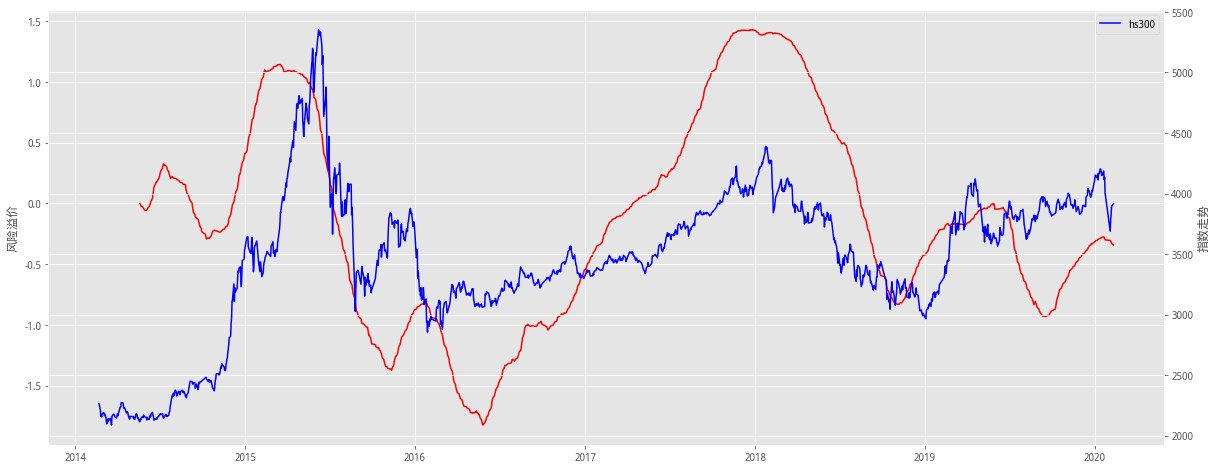

In [130]:
# 画图 风险溢价的60日均线与沪深300的走势图
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(final_df['singal1'], color ="red",label='singal')
ax1.set_ylabel('风险溢价')

ax2 = ax1.twinx()  # 设置双Y轴  
ax2.plot(final_df['price'], color ="blue",label='hs300')
ax2.set_ylabel('指数走势')
plt.legend(loc='best')
plt.show()

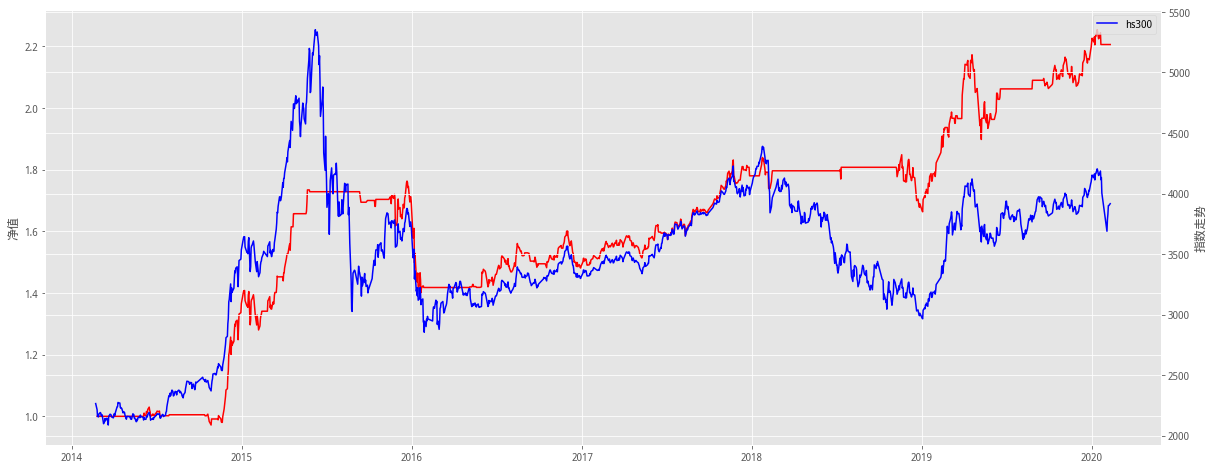

In [131]:
# 画图根据风险溢价择时交易的收益与基准沪深300的对比
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(final_df['singal2'],label='singal2')
# ax1.plot(final_df['singal'],label='singal')
ax1.plot(CUM_RET,color ="red",label='ret')
ax1.set_ylabel('净值')

ax2 = ax1.twinx()  # 设置双Y轴  
ax2.plot(final_df['price'], color ="blue",label='hs300')
ax2.set_ylabel('指数走势')
plt.legend(loc='best')
plt.legend()
plt.show()

In [132]:
# 收益的各项统计
def summary(df):
    
    
    def format_x(x):
        return '{:.2%}'.format(x)

    summary_dic = {}
    index_name = '年华收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
    亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
    单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(
        ',')
        
    RET = df['ret']*df["positon"]
    CUM_RET = (1+RET).cumprod()
        
    # 计算年华收益率
    annual_ret = CUM_RET[-1]**(250/len(RET)) - 1
        
    # 计算累计收益率
    cum_ret_rate = CUM_RET[-1] - 1

    # 最大回撤
    max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
    mdd = -np.min(CUM_RET / max_nv - 1)
        
    # 夏普
    sharpe_ratio = np.mean(RET)/np.nanstd(RET, ddof=1)*np.sqrt(250)
        
    # 标记买入卖出时点
    mark = df["positon"]
    pre_mark = np.nan_to_num(df["positon"].shift(-1))
    # 买入时点
    trade = (mark >= 1) & (pre_mark < mark)
    # 交易次数
    trade_count = np.nansum(trade)

    # 持仓总天数
    total = np.sum(mark)
    # 平均持仓天数
    mean_hold = total/trade_count
    # 获利天数
    win = np.sum(np.where(RET > 0, 1, 0))
    # 亏损天数
    lose = np.sum(np.where(RET < 0, 1, 0))
    # 胜率
    win_ratio = win/total
    # 平均盈利率（天）
    mean_win_ratio = np.sum(np.where(RET > 0, RET, 0))/win
    # 平均亏损率（天）
    mean_lose_ratio = np.sum(np.where(RET < 0, RET, 0))/lose
    # 盈亏比(天)
    win_lose = win/lose

    # 盈利次数
    temp_df = df.copy()
    diff = temp_df["positon"] != temp_df["positon"].shift(1)
    temp_df['mark'] = diff.cumsum()
    # 每次开仓的收益率情况
    temp_df = temp_df.query("positon"+'==1').groupby('mark')['ret'].sum()
    
    # 盈利次数
    win_count = np.sum(np.where(temp_df > 0, 1, 0))
    # 亏损次数
    lose_count = np.sum(np.where(temp_df < 0, 1, 0))
    # 单次最大盈利
    max_win = np.max(temp_df)
    # 单次最大亏损
    max_lose = np.min(temp_df)
    # 胜率
    win_rat = win_count/len(temp_df)
    # 平均盈利率（次）
    mean_win = np.sum(np.where(temp_df > 0, temp_df, 0))/len(temp_df)
    # 平均亏损率（天）
    mean_lose = np.sum(np.where(temp_df<0, temp_df, 0))/len(temp_df)
    # 盈亏比(次)
    mean_wine_lose = win_count/lose_count

    summary_dic["position"] = [format_x(annual_ret), format_x(cum_ret_rate),sharpe_ratio,format_x(
            mdd), total, trade_count, mean_hold, win, lose, format_x(win_ratio), format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count, format_x(
                max_win), format_x(max_lose),
            format_x(win_rat), format_x(mean_win), format_x(mean_lose), mean_wine_lose]
        
    summary_df=pd.DataFrame(summary_dic,index=index_name)
    summary_df.columns=["basic"]
    return summary_df

In [133]:
display(HTML(summary(final_df).to_html()))

,basic
年华收益率,14.63%
累计收益率,120.52%
夏普比率,1.0385
最大回撤,20.52%
持仓总天数,753
交易次数,67
平均持仓天数,11.2388
获利天数,410
亏损天数,343
胜率(按天),54.45%
